# Steinschlagrisiko cwm1

## Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


## Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0

NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## 1. Bibliotheken Importieren

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## 2. Vorbereitung der Daten
### 2.1 Daten einlesen und reinigen

In [2]:
# Daten laden
df1 = pd.read_csv("out_1.csv")
df2 = pd.read_csv("out_2.csv")

# Spaltennamen von df2 ändern so dass sie die Spaltennamen von df1 entsprechen
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"})

# Datentabelle auswählen
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]

# Spalte Ablösungszone hinzufügen
df1['Ablösungszone'] = 1
df2['Ablösungszone'] = 2

# Zeilen mit NA Werte löschen
df1 = df1.dropna()
df2 = df2.dropna()

Datum und Uhrzeit in einer Spalte zusammenfügen damit daraus einen Datetime Objekt erstellt werden kann.

In [3]:
df1["Datum"] = pd.to_datetime(df1["Datum"] + " " + df1["Uhrzeit"])
df2["Datum"] = pd.to_datetime(df2["Datum"] + " " + df2["Uhrzeit"])

# Uhrzeit Zeile löschen da diese nicht mehr gebraucht wird.
df1 = df1.drop("Uhrzeit", axis=1)
df2 = df2.drop("Uhrzeit", axis=1)

In [4]:
df1

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
63,2019-03-18 16:00:00,167.0,8.9,1
64,2019-03-22 18:00:00,2847.0,7.0,1
65,2019-03-26 00:00:00,44.0,8.9,1
66,2019-03-26 06:00:00,45.0,8.4,1


In [5]:
df2

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,38.0,45.4,2
1,2019-01-03 06:00:00,187.0,41.6,2
2,2019-01-04 10:00:00,36.0,44.6,2
3,2019-01-07 14:00:00,6.0,41.2,2
4,2019-01-11 06:00:00,65.0,39.6,2
5,2019-01-11 16:00:00,58.0,33.2,2
6,2019-01-14 11:00:00,365.0,40.2,2
7,2019-01-16 02:00:00,22.0,46.5,2
8,2019-01-18 06:00:00,146.0,36.2,2
9,2019-01-19 17:00:00,29.0,38.3,2


### 2.3 0 kg - Wert ersetzen
Bei Ablösungszone 2 beträgt die Masse eines Steines 0kg (siehe Zeile 23). Anhand der Grundlagen gilt: "Die Masse ist eine Experten-Schätzung des Geologen". Nach dieser Aussage fanden wir es sehr komisch, dass der Geolog dieses Stein mit einer Masse von 0kg schätzte. 

Wir nehmen also an, dass das Stein bei der Messung vergessen ging. 

Da die Masse nicht 0 sein kann, setzen wir für diese Masse den Median aller Massen aus Zone 2 ein, weil der Median robuster ist als der Durchschnitt. 

Hinweis: Der 0 Wert hatte keinen Einfluss auf den Median.

In [6]:
# Median berechnen
m = np.median(df2["Masse [kg]"])

list_mass_zone2 = []
        
# 0-Wert mit Median ersetzen
for i in range(len(df2["Masse [kg]"])):
    if df2["Masse [kg]"][i] <= 0:
        df2["Masse [kg]"][i] = m
        
# Prüfung, dass der neue Wert übernommen wurde
df2["Masse [kg]"][23]

<ipython-input-6-f638872531fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Masse [kg]"][i] = m


58.0

## 3. Exploratives Datenanalyse

### 3.1 Histogramme

In [7]:
def genHist(data, label):
    plt.figure(figsize=(7, 7), dpi= 70, facecolor="w", edgecolor="k")
    plt.hist(data, density=False, bins=40)
    plt.ylabel("Häufigkeit")
    plt.xlabel(label);   

#### Ablösungszone 1

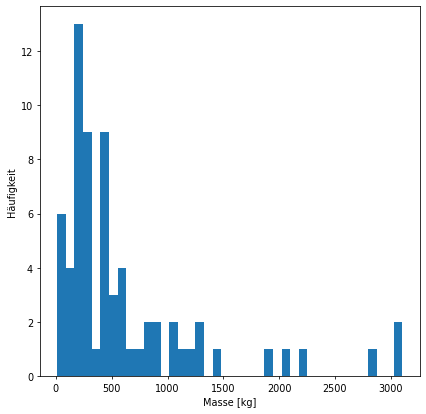

In [8]:
genHist(df1["Masse [kg]"], "Masse [kg]")

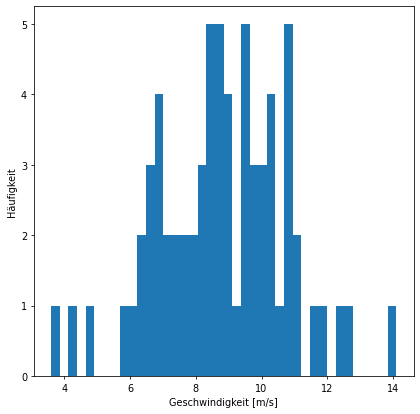

In [9]:
genHist(df1["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]")

#### Ablösungszone 2

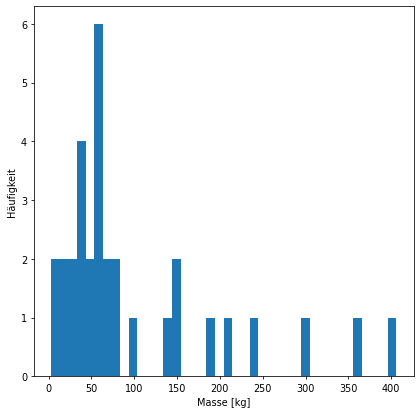

In [10]:
genHist(df2["Masse [kg]"], "Masse [kg]")

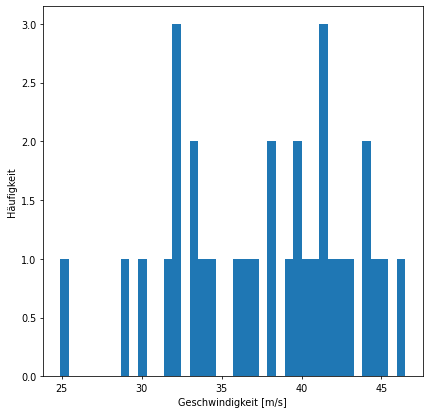

In [11]:
genHist(df2["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]")

### 3.2 Streudiagramme

#### Ablösungszone 1

In [12]:
def genScatter(data_x, data_y, label_x, label_y, lim_x, lim_y):
    plt.figure(figsize=(8, 8), dpi= 70, facecolor="w", edgecolor="k")

    plt.scatter(data_x, data_y)

    plt.gca().set(xlim=(0.0, lim_x), ylim=(0, lim_y), xlabel=label_x, ylabel=label_y)

    plt.title("Scatterplot von {} vs {}".format(label_x, label_y), fontsize=20)
    plt.legend(fontsize=12)    
    plt.show()    

No handles with labels found to put in legend.


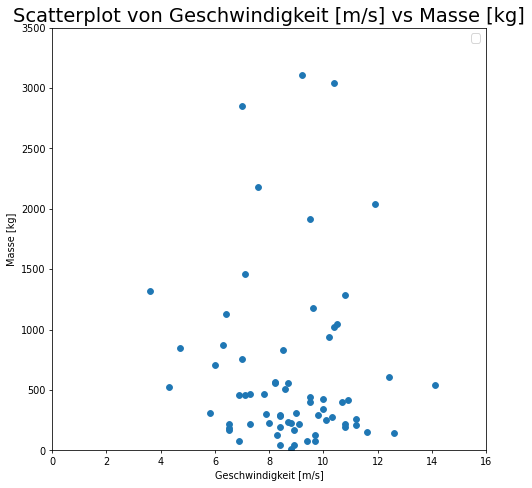

In [13]:
genScatter(df1["Geschwindigkeit [m/s]"], df1["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 16, 3500)

#### Ablösungszone 2

No handles with labels found to put in legend.


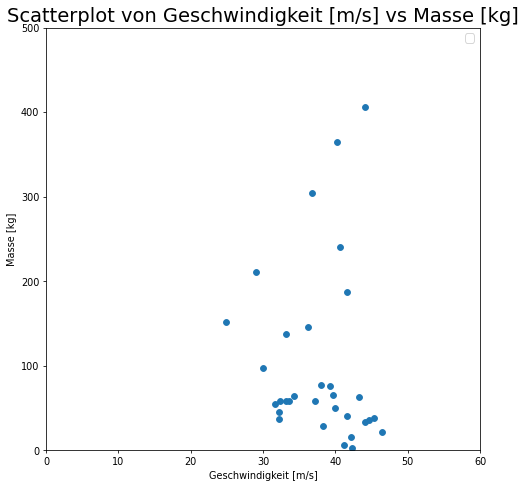

In [14]:
genScatter(df2["Geschwindigkeit [m/s]"], df2["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 60, 500)

### 3.3 Vergleich Ablösungszone 1 und 2

#### Tabellen zusammenfügen

In [15]:
df3 = pd.concat([df1, df2], ignore_index=True)

#### 3.3.1 Histogramm Masse

In [16]:
def genGroupedHist(dataframe, x_var):
    # Prepare data
    groupby_var = "Ablösungszone"
    df_agg = dataframe.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [dataframe[x_var].values.tolist() for i, dataframe in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(dataframe[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, 25)
    plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
    plt.show()

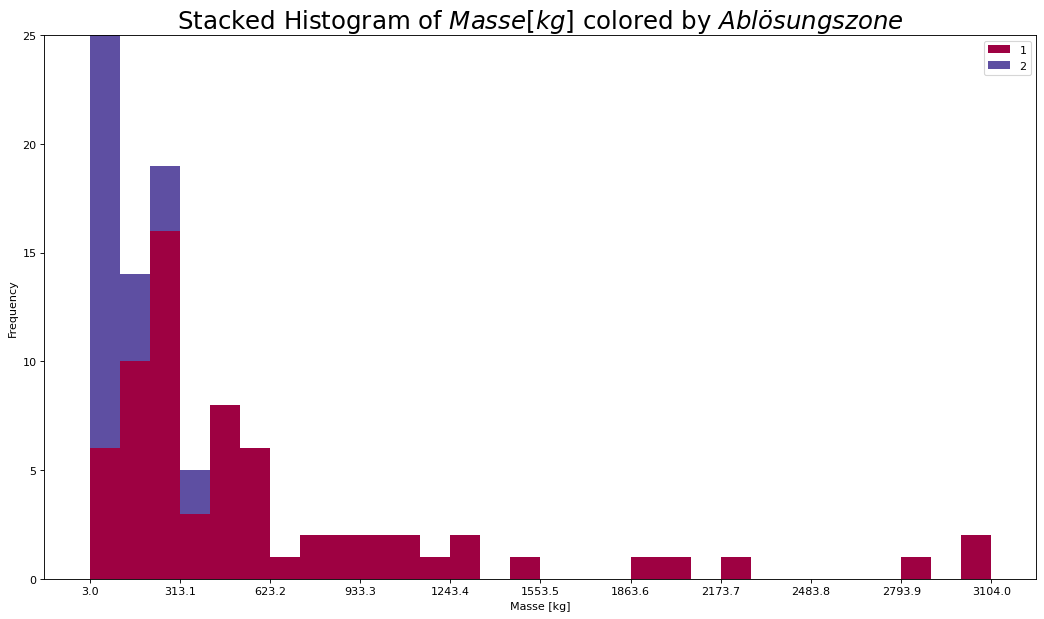

In [17]:
genGroupedHist(df3, "Masse [kg]")

#### 3.3.2 Histogramm Geschwindigkeit

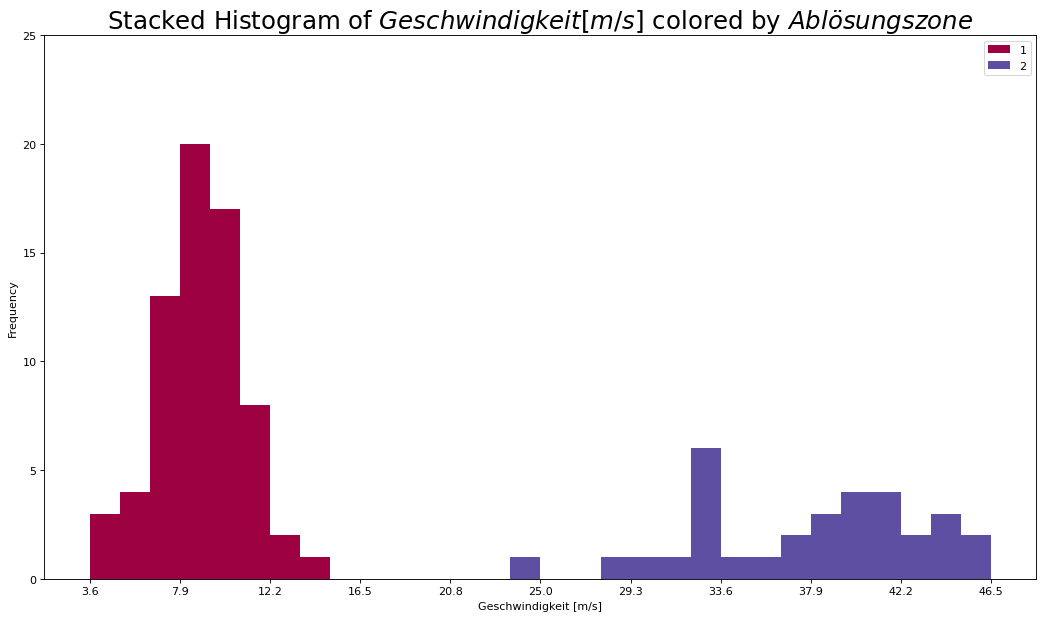

In [18]:
genGroupedHist(df3, "Geschwindigkeit [m/s]")

#### 3.3.3 Streudiagramm

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


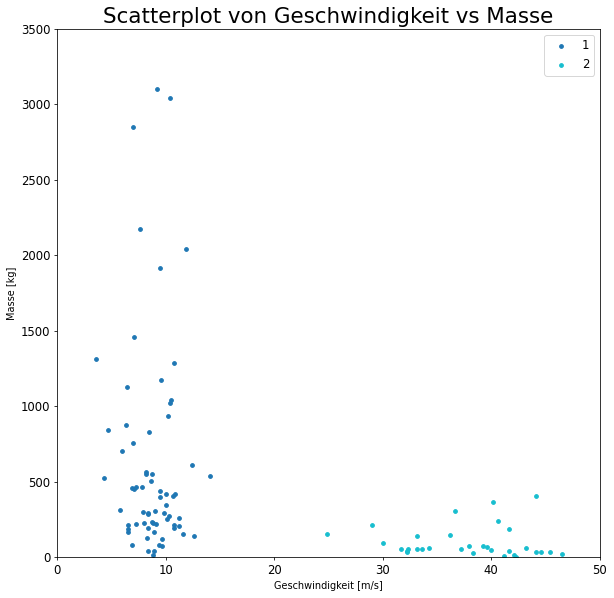

In [19]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### 3.3.4 Bemerkungen

Ablösungszone 1 und 2 sollte man nicht kombinieren, weil die Datensätze stark unterschiedlich sind. Wir nehmen an, dass Ablösungszone 2 steiler ist als Zone 1, aufgrund von der Geschwindigkeit. Bei Ablösungszone 1 befinden sich deutlich massenhaftere Steine als bei Zone 2.

### 3.4 Statistik

In [20]:
df1.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,68.000000,68.000000,68.0
mean,628.632353,8.788235,1.0
std,695.884703,1.989189,0.0
min,12.000000,3.600000,1.0
25%,214.750000,7.300000,1.0
50%,402.500000,8.800000,1.0
75%,773.000000,10.125000,1.0
max,3104.000000,14.100000,1.0


In [21]:
df2.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,32.000000,32.000000,32.0
mean,101.062500,37.790625,2.0
std,102.785382,5.395778,0.0
min,3.000000,24.900000,2.0
25%,37.750000,33.200000,2.0
50%,58.000000,38.750000,2.0
75%,140.000000,41.725000,2.0
max,406.000000,46.500000,2.0


## 4. Berechnungen

### 4.3 Zeitbstand von Steinschlägen berechnen
Wir berechnen jetzt die Zeitabstände in Stunden von den Steinschlägen damit wir eine Normalverteilung aufstellen können.

In [22]:
def calcAverage(lst, i):
    return round(sum(lst) / float(len(lst)-i),1)

In [23]:
def calcTimeDistance(zone):
    time_distances = []
    for i in range(len(zone)):
        try: 
            distance = int(abs(zone[i] - zone[i+1]).total_seconds() / 3600)
            time_distances.append(distance)
        except Exception:
            pass 
        
    return time_distances

In [24]:
# Create lists with times
dates_zone1 = list(i for i in df1["Datum"])
dates_zone2 = list(i for i in df2["Datum"])

# Calculate time between each rockfall for zone 1 & 2
time_dist_zone1 = calcTimeDistance(dates_zone1)
time_dist_zone2 = calcTimeDistance(dates_zone2)

In [25]:
# Dataframe mit Zeitabsständn erstellen
df_Zeitabstand_1 = pd.DataFrame(time_dist_zone1)
df_Zeitabstand_2 = pd.DataFrame(time_dist_zone2)

## 5. Wahrscheinlichkeitsverteilungen (Zufallsvariablen)

### 5.1 Wahrscheinlichkeits Dichteplot (PDF)

In [26]:
# Nur ausgeben der der Variabeln mu und sigma der Normalverteilung
# Fehler : ein kleines Rechteck wird zusätzlich erstellt
def get_fitted_par(dataframe, x_val, distr):
    vals = dataframe[x_val].values
    fitter_vals = Fitter(vals,
               distributions=['alpha',
                              'beta',
                              "gamma",
                              "norm",
                              "expon",
                              "lognorm",
                              "cauchy",
                              "exponpow",
                              "powerlaw"])
    fitter_vals.fit()
    if distr == "norm":
        return fitter_vals.fitted_param["norm"]
    elif distr == "expon":
        return fitter_vals.fitted_param["expon"]
    elif distr == "gamma":
        return fitter_vals.fitted_param["gamma"]
    elif distr == "cauchy":
        return fitter_vals.fitted_param["cauchy"]
    elif distr == "exponpow":
        return fitter_vals.fitted_param["exponpow"]
    elif distr == "powerlaw":
        return fitter_vals.fitted_param["powerlaw"]
    else:
        return "Error"

In [27]:
def best_distribution(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data=dataframe, x = x_val, kind = "hist", bins = 150, aspect = 2.0)
    vals = dataframe[x_val].values
    
    fitter_vals = Fitter(vals, distributions=get_common_distributions())
    fitter_vals.fit()
    fitter_vals.summary()
    return fitter_vals.get_best(method = 'sumsquare_error')

In [28]:
def expon_distribution(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data=dataframe, x = x_val, kind = "hist", bins = 150, aspect = 2.0)
    vals = dataframe[x_val].values        
    
    fitter_vals = Fitter(vals,
               distributions=['alpha',
                              'beta',
                              "gamma",
                              "norm",
                              "expon",
                              "lognorm"])
    
    
    fitter_vals.fit()
    fitter_vals.summary()
    return fitter_vals.fitted_param["expon"]

#### Ablösungszone 1

(12.0, 616.6323529411765)


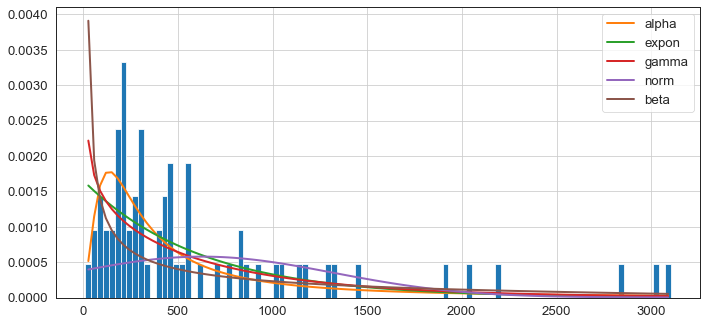

In [29]:
# Masse
distribution_mass1_param = expon_distribution(df1, "Masse [kg]")
print(distribution_mass1_param)

{'norm': {'loc': 8.788235294117646, 'scale': 1.9745088303442118}}


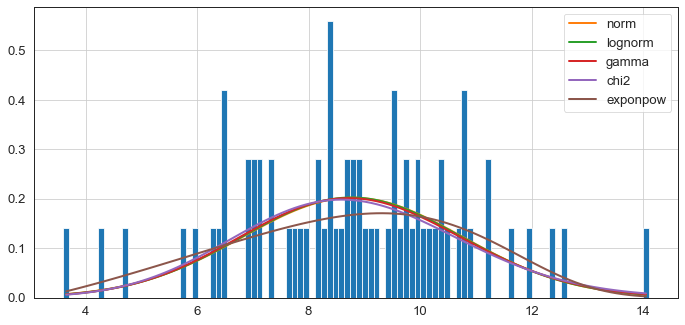

In [30]:
# Geschwindigkeit
distribution_speed1_param = best_distribution(df1, "Geschwindigkeit [m/s]")
print(distribution_speed1_param)

{'gamma': {'a': 0.7720943018929209, 'loc': -2.1070777126863917e-25, 'scale': 32.180388904581854}}


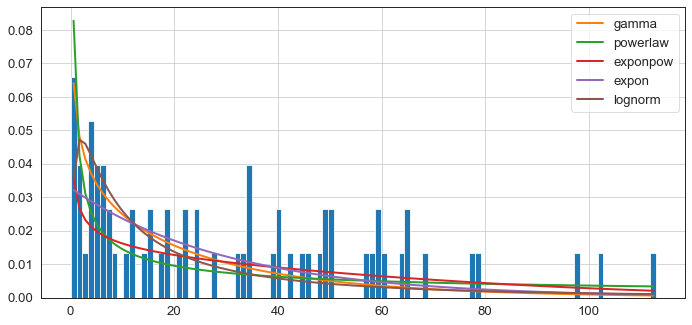

In [31]:
# Zeitabstand
distribution_time1_param = best_distribution(df_Zeitabstand_1, 0)
print(distribution_time1_param)

#### Ablösungszone 2

(3.0, 98.0625)


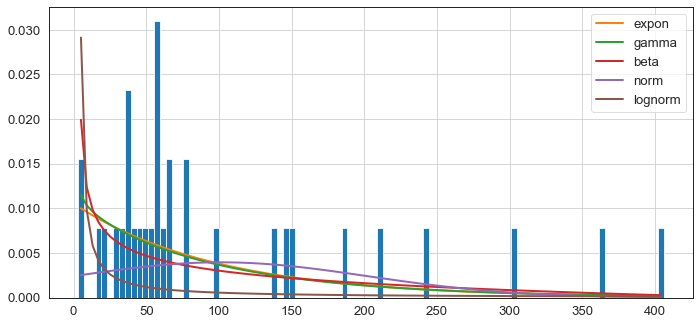

In [32]:
# Masse
distribution_mass2_param = expon_distribution(df2, "Masse [kg]")
print(distribution_mass2_param)

{'powerlaw': {'a': 1.6225211698026003, 'loc': 24.037051269746893, 'scale': 22.46294873394062}}


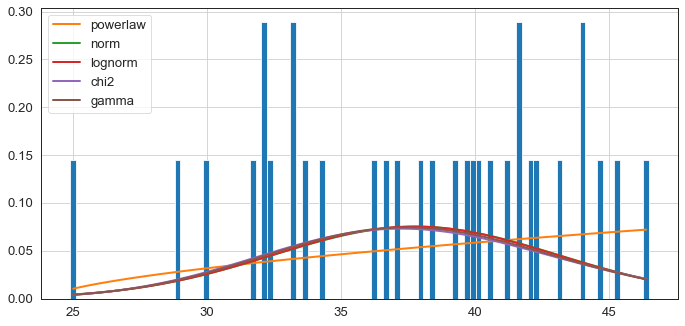

In [33]:
# Geschwindigkeit
distribution_speed2_param = best_distribution(df2, "Geschwindigkeit [m/s]")
print(distribution_speed2_param)

{'exponpow': {'b': 0.6971027826831848, 'loc': 6.999999999999999, 'scale': 117.24076793057438}}


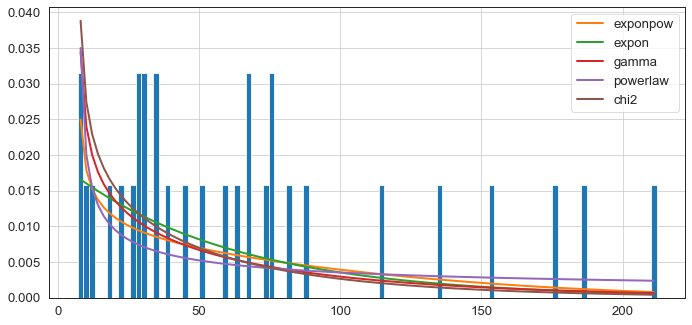

In [34]:
# Zeitabstand
distribution_time2_param = best_distribution(df_Zeitabstand_2, 0)
print(distribution_time2_param)

### 5.2 Kummultative Funktionsverteilung (CDF)

In [35]:
def cdf_function(dataframe, attribute, xachse, distr):
    
    # Gleichmässige Punkteveteilung auf der x-Achse
    x = np.linspace(min(dataframe[attribute]),max(dataframe[attribute]), 10000)
    
    plt.figure(figsize=(10, 5), dpi= 70, facecolor='w', edgecolor='k')
    
    # Holen die nötigen Parameter und Plottet
    if distr == "norm":
        loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.norm.cdf(x, loc, scale), color="red")
    elif distr == "expon":
        loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.expon.cdf(x, loc, scale), color="red")
    elif distr == "gamma":
        a, loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.gamma.cdf(x, a, loc, scale), color="red")
    elif distr == "cauchy":
        loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.cauchy.cdf(x, loc, scale), color="red")
    elif distr == "exponpow":
        b, loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.exponpow.cdf(x, b, loc, scale), color="red")
    elif distr == "powerlaw":
        a, loc, scale = get_fitted_par(dataframe, attribute, distr)
        plt.plot(x,stats.powerlaw.cdf(x, a, loc, scale), color="red")
    
    plt.hist(dataframe[attribute], cumulative=True, density=True, bins=300)
    plt.ylabel("P(X<=x)")
    plt.xlabel(xachse)
    plt.title("Kummulutative Funktionsverteilung der {}".format(attribute))

#### Ablösungszone 1

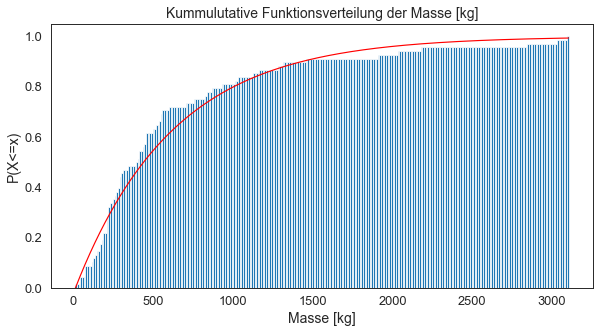

In [36]:
cdf_function(df1, "Masse [kg]", "Masse [kg]", "expon")

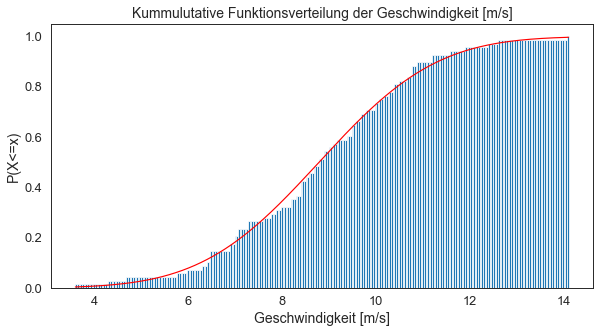

In [37]:
cdf_function(df1, "Geschwindigkeit [m/s]", "Geschwindigkeit [m/s]", "norm")

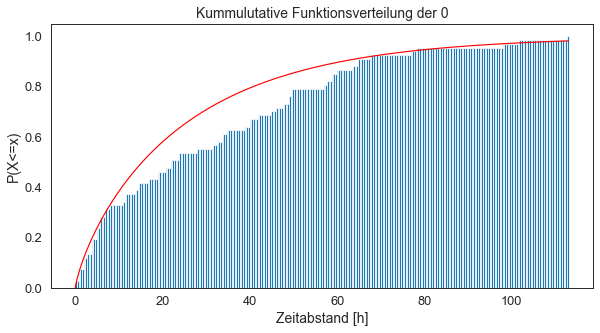

In [38]:
cdf_function(df_Zeitabstand_1, 0, "Zeitabstand [h]", "gamma")

#### Ablösungszone 2

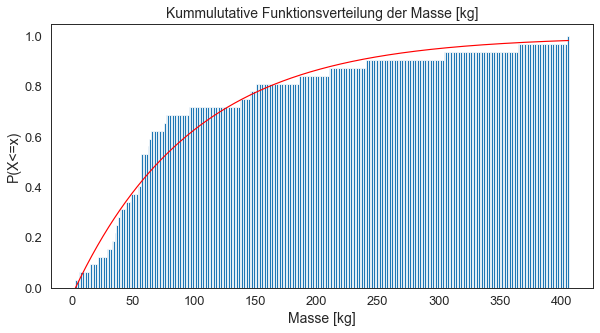

In [39]:
cdf_function(df2, "Masse [kg]", "Masse [kg]", "expon")

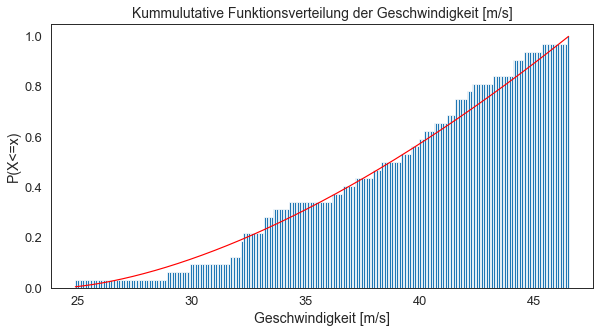

In [40]:
cdf_function(df2, "Geschwindigkeit [m/s]", "Geschwindigkeit [m/s]", "powerlaw")

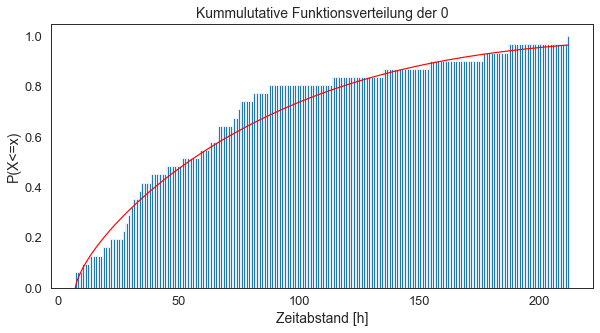

In [41]:
cdf_function(df_Zeitabstand_2, 0, "Zeitabstand [h]", "exponpow")

## 6. Simulation von Masse, Geschwindigkeit und Zeit

In [60]:
# Anzahl Daten für die Simulationen
sim_size1 = 50_000_000
sim_size2 = round(sim_size1 / 3)

np.random.seed(seed=5)

In [61]:
def plotDistr(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)   

### 6.1 Ablösungszone 1

#### 6.1.1 Masse

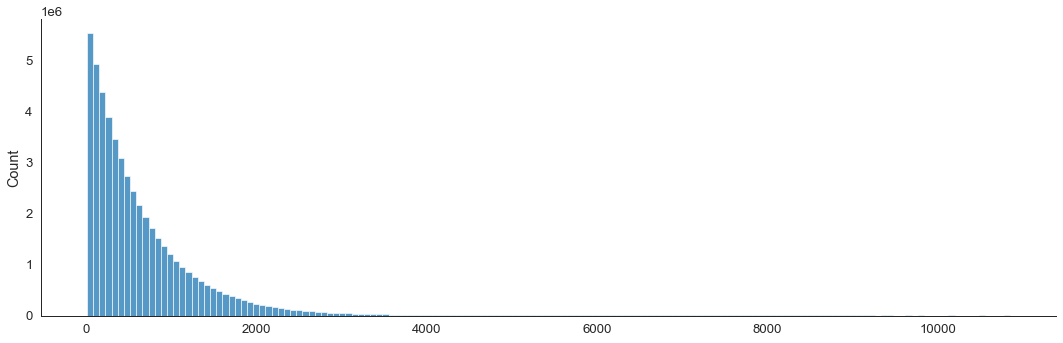

In [62]:
loc, scale = get_fitted_par(df1, "Masse [kg]", "expon")
sim_mass_zone1 = stats.expon.rvs(loc, scale, sim_size1) 
df_sim_mass_zone1 = pd.DataFrame(sim_mass_zone1)

plotDistr(df_sim_mass_zone1, sim_mass_zone1)

#### 6.1.2 Geschwindigkeit

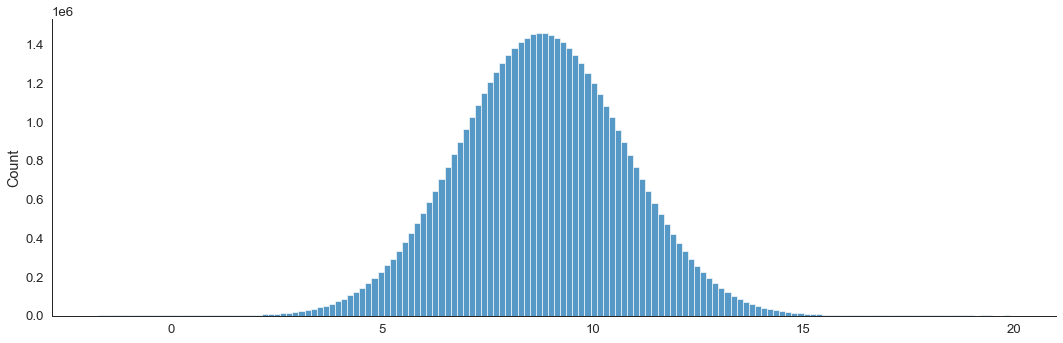

In [63]:
loc, scale = get_fitted_par(df1, "Geschwindigkeit [m/s]", "norm")
sim_speed_zone1 = stats.norm.rvs(loc, scale, sim_size1)
df_sim_speed_zone1 = pd.DataFrame(sim_speed_zone1)

plotDistr(df_sim_speed_zone1, sim_speed_zone1)

#### 6.1.3 Zeit

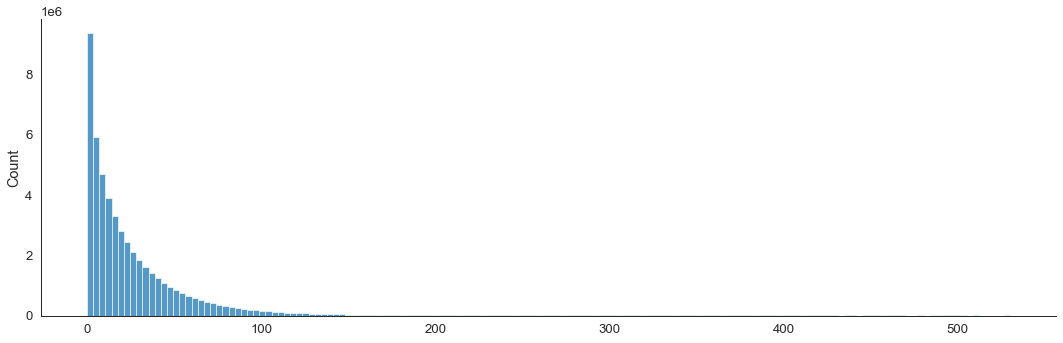

In [64]:
a, loc, scale = get_fitted_par(df_Zeitabstand_1, 0, "gamma")
sim_time_zone1 = stats.gamma.rvs(a, loc, scale, sim_size1)
df_sim_time_zone1 = pd.DataFrame(sim_time_zone1)

plotDistr(df_sim_time_zone1, sim_time_zone1)

### 6.2 Ablösungszone 2

#### 6.2.1 Masse

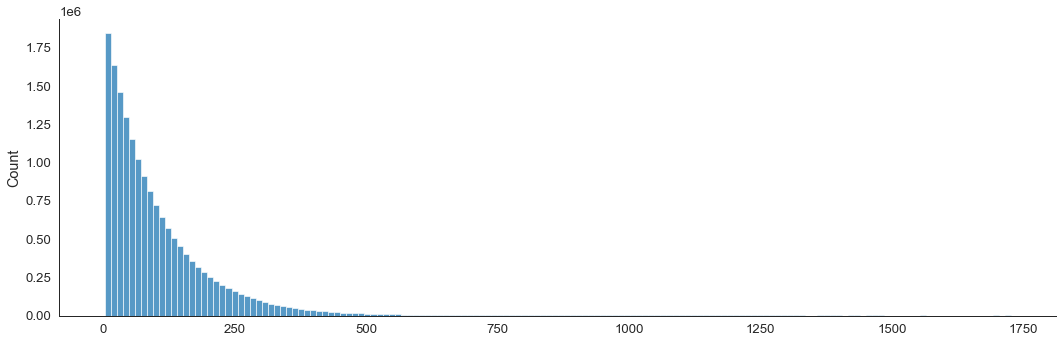

In [65]:
loc, scale = get_fitted_par(df2, "Masse [kg]", "expon")
sim_mass_zone2 = stats.expon.rvs(loc, scale, sim_size2) 
df_sim_mass_zone2 = pd.DataFrame(sim_mass_zone2)

plotDistr(df_sim_mass_zone2, sim_mass_zone2)

#### 6.2.2 Geschwindigkeit

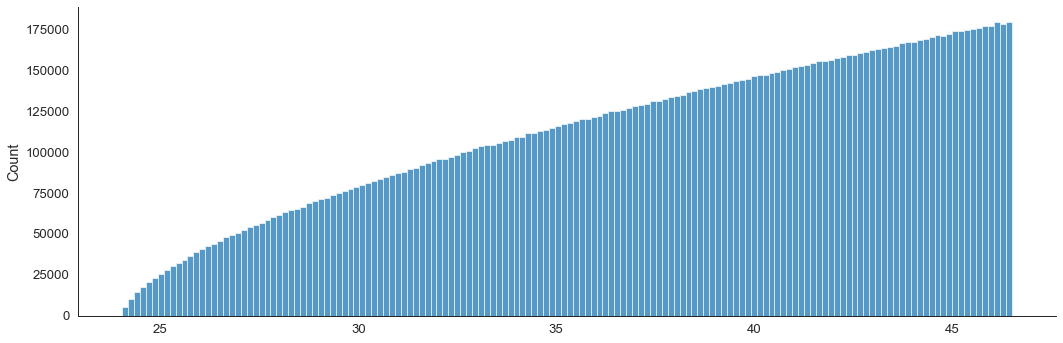

In [66]:
a, loc, scale = get_fitted_par(df2, "Geschwindigkeit [m/s]", "powerlaw")
sim_speed_zone2 = stats.powerlaw.rvs(a, loc, scale, sim_size2)
df_sim_speed_zone2 = pd.DataFrame(sim_speed_zone2)

plotDistr(df_sim_speed_zone2, sim_speed_zone2)

#### 6.2.3 Zeit

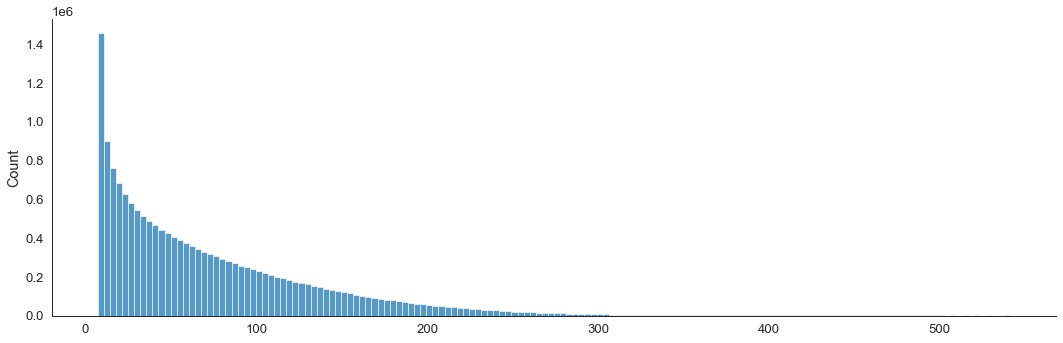

In [67]:
b, loc, scale = get_fitted_par(df_Zeitabstand_2, 0, "exponpow")
sim_time_zone2 = stats.exponpow.rvs(b, loc, scale, sim_size2)
df_sim_time_zone2 = pd.DataFrame(sim_time_zone2)

plotDistr(df_sim_time_zone2, sim_time_zone2)

### 6.3 Dataframe der Simulationen

Hier fügen wir die Daten aus der Simulationen in einem Dataframe zusammen. Dazu werden noch die Zeilenbeschriftungen umbenennt.

In [68]:
# Simulierte Masse, Geschwindigkeit, Zeit zusammenfügen
df_simulation_zone1 = pd.concat([df_sim_mass_zone1, df_sim_speed_zone1, df_sim_time_zone1], axis=1, join="inner")
df_simulation_zone2 = pd.concat([df_sim_mass_zone2, df_sim_speed_zone2, df_sim_time_zone2], axis=1, join="inner")

# Spalten umbenennen
df_simulation_zone1.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]
df_simulation_zone2.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]

# Berechnung der Energie und Spalte hinzufügen
df_simulation_zone1["Energie [kj]"] = (0.5 * df_simulation_zone1["Masse [kg]"] * \
                                       df_simulation_zone1["Geschwindigkeit [m/s]"] ** 2) / 1000
df_simulation_zone2["Energie [kj]"] = (0.5 * df_simulation_zone2["Masse [kg]"] * \
                                       df_simulation_zone2["Geschwindigkeit [m/s]"] ** 2) / 1000

# Position der Energiespalte geaendert
df_simulation_zone1 = df_simulation_zone1[["Masse [kg]", "Geschwindigkeit [m/s]", "Energie [kj]", "Zeitabstand [h]"]]
df_simulation_zone2 = df_simulation_zone2[["Masse [kg]", "Geschwindigkeit [m/s]", "Energie [kj]", "Zeitabstand [h]"]]

# Kummulierter Zeitabstand berechnen
df_simulation_zone1["Kumm. Zeitabstand [h]"] = df_simulation_zone1["Zeitabstand [h]"].cumsum().round(1)
df_simulation_zone2["Kumm. Zeitabstand [h]"] = df_simulation_zone2["Zeitabstand [h]"].cumsum().round(1)

In [69]:
# Zone 1 auf den kummulierten Zeitabstand von Zone 2 anpassen, weil sonst nur noch Zone 1 simuliert wird.

df_simulation_zone1 = df_simulation_zone1.drop(
    df_simulation_zone1[df_simulation_zone1["Kumm. Zeitabstand [h]"] > max(df_simulation_zone2["Kumm. Zeitabstand [h]"])].index)

print(sum(df_simulation_zone1["Zeitabstand [h]"]))
print(sum(df_simulation_zone2["Zeitabstand [h]"]))

1190043061.99871
1190043096.0416448


In [70]:
# Beide Dataframes zusammenfuegen
frames = [df_simulation_zone1, df_simulation_zone2]
df_simulation = pd.concat(frames)

# Nach Kummulierte Zeit aufsteigend sortieren
df_simulation = df_simulation.sort_values(by=["Kumm. Zeitabstand [h]"])

# Index neu nummerieren
df_simulation = df_simulation.reset_index()

# Alte Index Spalte löschen
df_simulation = df_simulation.drop(['index'], axis=1)

# Differenz der Kummulierten Zeit berechnen sowie NA Wert der Delta Kummulierte Zeit durch 0 ersetzten
df_simulation["Delta Kumm. Zeitabstand [h]"] = df_simulation["Kumm. Zeitabstand [h]"].diff().fillna(0)

# Negative Werte im Dataframe loeschen
df_simulation = df_simulation[(df_simulation["Geschwindigkeit [m/s]"] > 0)]

In [71]:
# Anzahl simmulierte Jahre berechnen
# Stunden in 1 Jahr: 8760
verstrichene_zeit = sum(df_simulation["Zeitabstand [h]"]) 
zeit_in_jahr = verstrichene_zeit / 8760
print(zeit_in_jahr)

271698.7910669802


## 7. Netz
Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher.
Netz Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).

### 7.1 Durchbruch aufgrund der Energie und Masse

In [74]:
def durchbruch(masse, energie, kum_masse):
    if energie >= 1000:
        return True
    elif energie >= 500 and kum_masse >= 2000:
        return True
    else:
        return False

In [75]:
kum_zeitabstand = 0
kum_masse = 0
anz_durchbrüche = 0

for row in df_simulation.itertuples():   
    masse = row[1]
    geschw = row[2]
    energie = row[3]
    zeitabstand = row[4]
    
    if durchbruch(masse, energie, kum_masse):
        anz_durchbrüche += 1
        #print("Durchbruch:\n{}".format(row))
    
    if zeitabstand >= 24 :
        kum_zeitabstand = 0
        kum_masse = 0
        
    if zeitabstand + kum_zeitabstand >= 24:
        kum_zeitabstand = 0
        kum_masse = 0
        
    else:
        kum_zeitabstand += zeitabstand
        kum_masse += masse
        
print("Anzahl Durchbrüche: {}".format(anz_durchbrüche))      

# Durchbrüche pro Jahr:
durchbruch_pro_jahr = anz_durchbrüche / zeit_in_jahr
print(durchbruch_pro_jahr)

Anzahl Durchbrüche: 2155
0.007931577433735217


## 8. Verkehr
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h.

In [122]:
anz_autos = 1200
anz_autos_stunden = 1200 / 24
anz_autos_minuten = 1200 / 24 / 60
anz_autos_sekunden = 1200 / 24 / 60 / 60

auto_geschw = 60
auto_länge = 2
anz_personen = 1.5
bremsweg = (auto_geschw / 10)**2
reaktionsweg = (auto_geschw / 10) * 3
anhalteweg = bremsweg + reaktionsweg
distanz_pro_sekunde = (auto_geschw / 3600) * 1000

# Stein fällt direkt aufs Auto
tödlicher_treffer = (auto_länge / distanz_pro_sekunde) * anz_autos_sekunden
print(tödlicher_treffer)

# Auto fährt in dem Stein
tödlicher_aufprall = reaktionsweg / distanz_pro_sekunde * anz_autos_sekunden * 0.05
print(tödlicher_aufprall)

tod_pro_jahr = (tödlicher_treffer + tödlicher_aufprall) * durchbruch_pro_jahr * anz_personen
print(f"{tod_pro_jahr:.9f}")

0.0016666666666666668
0.00075
0.000028752


## 9. Strassensperrung 

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4 ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.

In [124]:
if tod_pro_jahr >= 0.0001:
    print("Strasse wird gesperrt.")
else:
    print("Die Strasse ist sicher und muss nicht gesperrt werden.")
    
print("Die Todeswahrscheinlichkeit pro Jahr liegt bei {}".format(f"{tod_pro_jahr:.9f}"))

Die Strasse ist sicher und muss nicht gesperrt werden.
Die Todeswahrscheinlichkeit pro Jahr liegt bei 0.000028752


## 10. Fazit / Bericht